# Fiap Tech Challange: Estimar valor plano de saúde

### O problema:
Você é um profissional encarregado de desenvolver um modelo
preditivo de regressão para prever o valor dos custos médicos individuais
cobrados pelo seguro de saúde.

## Escolha da base dados.

Procurei uma base com dados do Brasil, no entanto, as bases públicas de fontes confiáveis já trazem os dados consolidados e não por beneficiário, o que inviabiliza a criação do modelo preditivo.

Fontes nacionais pesquisadas:

* https://www.gov.br/ans/pt-br/acesso-a-informacao/perfil-do-setor/dados-e-indicadores-do-setor
* https://datasus.saude.gov.br/informacoes-de-saude-tabnet/


Base selecionada no kaggle:

* https://www.kaggle.com/datasets/mirichoi0218/insurance?resource=download



# Imports

In [38]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import FunctionTransformer

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.ensemble import RandomForestRegressor
from sklearn.dummy import DummyRegressor

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from google.colab import drive
import joblib

# Explorando a base de dados

In [39]:
df = pd.read_csv("https://raw.githubusercontent.com/AlexandreSabino/fiap-tech-challenge-healthcare-predict/refs/heads/master/insurance.csv")

In [40]:
df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [41]:
df.describe()

,age,bmi,children,charges
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,1.094918,13270.422265
std,14.049960,6.098187,1.205493,12110.011237
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.296250,0.000000,4740.287150
50%,39.000000,30.400000,1.000000,9382.033000
75%,51.000000,34.693750,2.000000,16639.912515
max,64.000000,53.130000,5.000000,63770.428010


# Existem colunas nulas?



In [42]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


In [43]:
df.isnull().sum()

,0
age,0
sex,0
bmi,0
children,0
smoker,0
region,0
charges,0


# Quantas linhas / colunas eu tenho?

In [44]:
df.shape

(1338, 7)

# Existem dados duplicados?

In [45]:
df_duplicadas = df[df.duplicated()]
print(df_duplicadas)

     age   sex    bmi  children smoker     region    charges
581   19  male  30.59         0     no  northwest  1639.5631


In [46]:
quantidade = df.duplicated().sum()
print(f"Número de duplicatas: {quantidade}")

Número de duplicatas: 1


# Tratamento dos dados, transformando todas as colunas em campos numéricos.

Temos 3 colunas que precisamos tratar: sex, smoker, region.

sex e region: Como os dados são limitados usarei a estratégia de One-Hot Enconding.

smoker: é um campo booleano, usarei a estratégia LabelEnconder.

In [47]:
df_prepared = df.copy()

In [48]:
labelEncoder = LabelEncoder()
df_prepared['smoker'] = labelEncoder.fit_transform(df['smoker'])

In [49]:
def concatOneHotEnconding(oneHotEncoder, value_encoded, field_name, df):
  encoded_columns = oneHotEncoder.get_feature_names_out([field_name])
  encoded_df = pd.DataFrame(value_encoded, columns=encoded_columns, index=df.index)
  return pd.concat([df.drop(columns=[field_name]), encoded_df], axis=1)


In [50]:
oneHotEncoderSex = OneHotEncoder(sparse_output=False)

sex_encoded = oneHotEncoderSex.fit_transform(df_prepared[['sex']])
df_prepared =  concatOneHotEnconding(oneHotEncoderSex, sex_encoded, 'sex', df_prepared)
df_prepared.head()

,age,bmi,children,smoker,region,charges,sex_female,sex_male
0,19,27.900,0,1,southwest,16884.92400,1.0,0.0
1,18,33.770,1,0,southeast,1725.55230,0.0,1.0
2,28,33.000,3,0,southeast,4449.46200,0.0,1.0
3,33,22.705,0,0,northwest,21984.47061,0.0,1.0
4,32,28.880,0,0,northwest,3866.85520,0.0,1.0


In [51]:
oneHotEncoderRegion = OneHotEncoder(sparse_output=False)

region_encoded = oneHotEncoderRegion.fit_transform(df_prepared[['region']])
df_prepared =  concatOneHotEnconding(oneHotEncoderRegion, region_encoded, 'region', df_prepared)
df_prepared.head()

,age,bmi,children,smoker,charges,sex_female,sex_male,region_northeast,region_northwest,region_southeast,region_southwest
0,19,27.900,0,1,16884.92400,1.0,0.0,0.0,0.0,0.0,1.0
1,18,33.770,1,0,1725.55230,0.0,1.0,0.0,0.0,1.0,0.0
2,28,33.000,3,0,4449.46200,0.0,1.0,0.0,0.0,1.0,0.0
3,33,22.705,0,0,21984.47061,0.0,1.0,0.0,1.0,0.0,0.0
4,32,28.880,0,0,3866.85520,0.0,1.0,0.0,1.0,0.0,0.0


In [52]:
df_prepared.shape

(1338, 11)

Verificando se a transformação dos dados está correta

In [53]:
num_smokers_original = df[df['smoker'] == 'yes'].shape[0]
num_smokers_prepared = df_prepared[df_prepared['smoker'] == 1].shape[0]

sex_female_original = df[df['sex'] == 'female'].shape[0]
sex_female_prepared = df_prepared[df_prepared['sex_female'] == 1].shape[0]

region_northeast_original = df[df['region'] == 'northeast'].shape[0]
region_northeast_prepared = df_prepared[df_prepared['region_northeast'] == 1].shape[0]

region_northwest_original = df[df['region'] == 'northwest'].shape[0]
region_northwest_prepared = df_prepared[df_prepared['region_northwest'] == 1].shape[0]


print(f"Total Rows equals {len(df) == len(df_prepared)}")
print(f"Smokers equals {num_smokers_original == num_smokers_prepared}")
print(f"sex_female equals {sex_female_original == sex_female_prepared}")
print(f"region_northeast equals {region_northeast_original == region_northeast_prepared}")
print(f"region_northwest equals {region_northwest_original == region_northwest_prepared}")

Total Rows equals True
Smokers equals True
sex_female equals True
region_northeast equals True
region_northwest equals True


# Qual é a correlação dos dados?

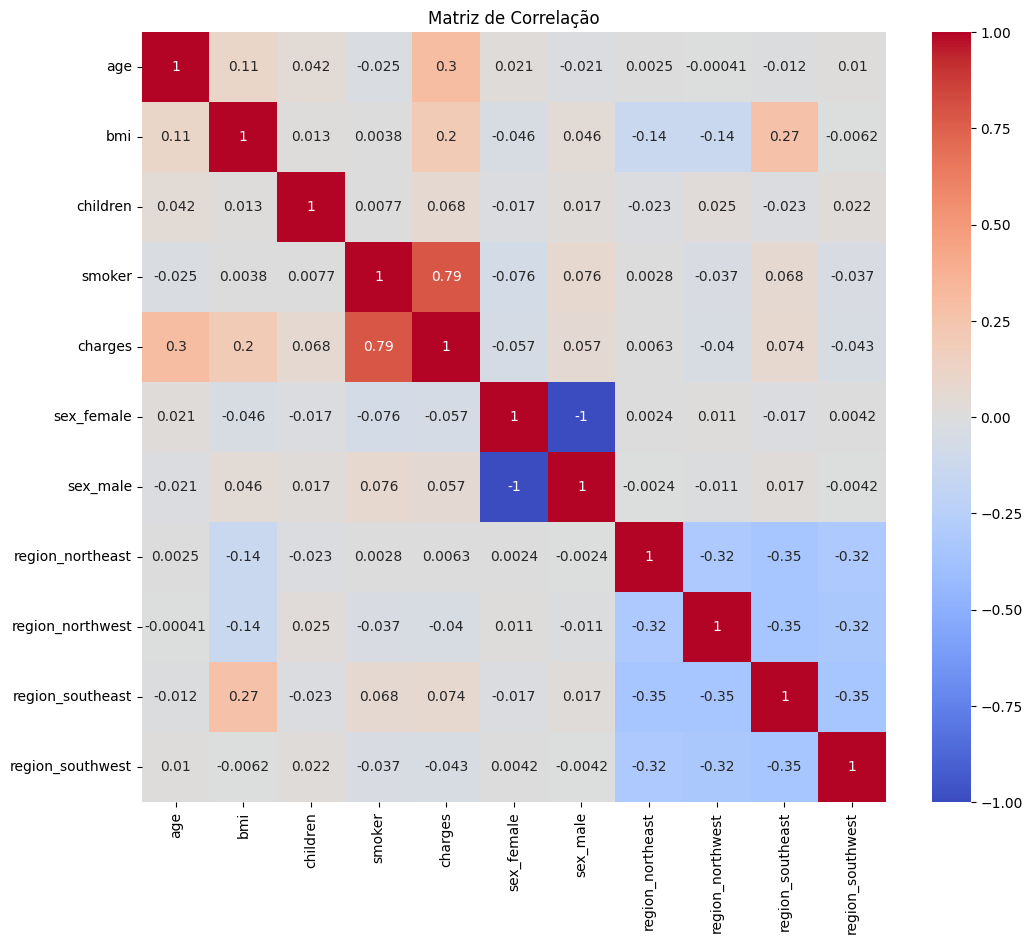

In [54]:
correlations = df_prepared.corr()
plt.figure(figsize=(12, 10))
sns.heatmap(correlations, annot=True, cmap='coolwarm')
plt.title("Matriz de Correlação")
plt.show()

# O plano de saude é mais caro para fumantes?

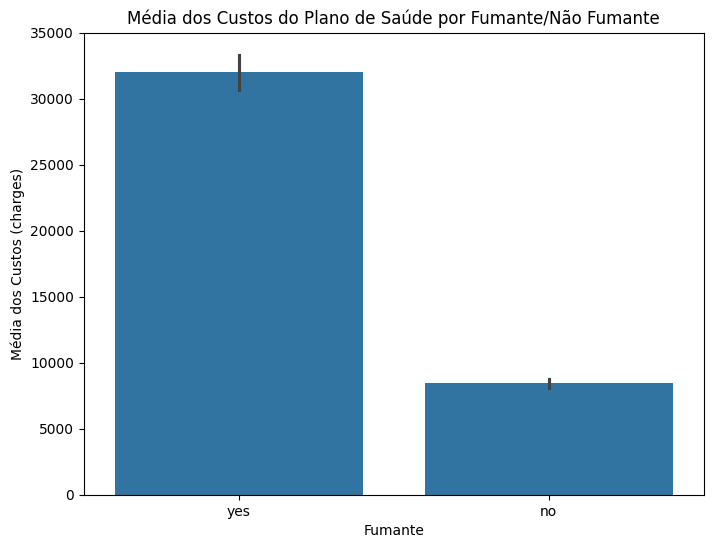

In [55]:
plt.figure(figsize=(8, 6))
sns.barplot(data=df, x='smoker', y='charges', estimator='mean')

plt.title("Média dos Custos do Plano de Saúde por Fumante/Não Fumante")
plt.xlabel("Fumante")
plt.ylabel("Média dos Custos (charges)")
plt.show()

# Existem diferenças no valor do plano de saúde por região?

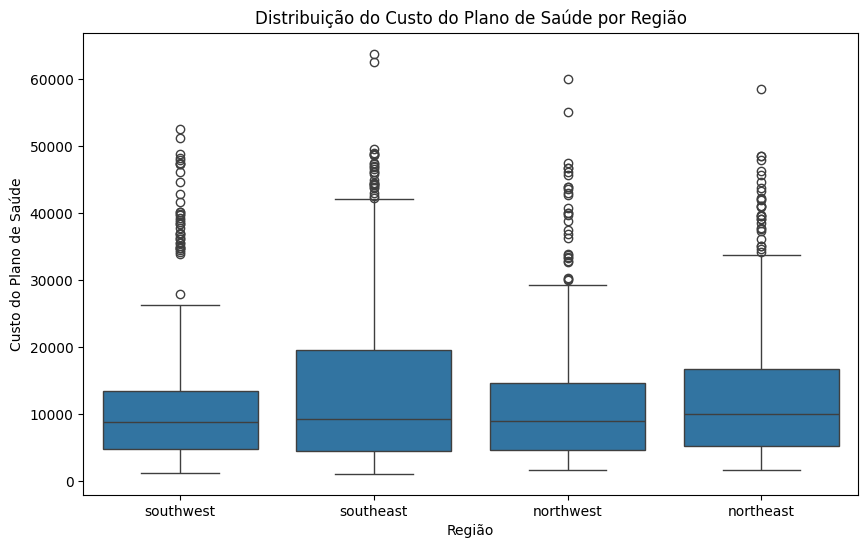

In [56]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=df, x='region', y='charges')

plt.title("Distribuição do Custo do Plano de Saúde por Região")
plt.xlabel("Região")
plt.ylabel("Custo do Plano de Saúde")
plt.show()

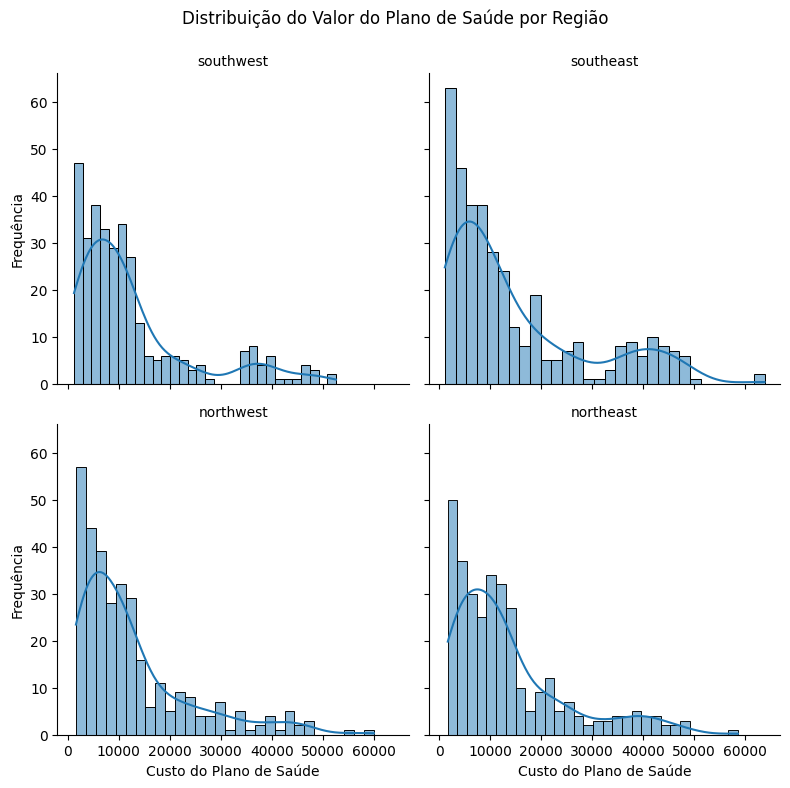

In [57]:
g = sns.FacetGrid(df, col="region", col_wrap=2, height=4)
g.map_dataframe(sns.histplot, x="charges", bins=30, kde=True)

g.set_titles(col_template="{col_name}")
g.set_axis_labels("Custo do Plano de Saúde", "Frequência")
plt.subplots_adjust(top=0.9)
g.fig.suptitle("Distribuição do Valor do Plano de Saúde por Região")
plt.show()

# Existem diferenças no valor do plano de saúde por Gênero?

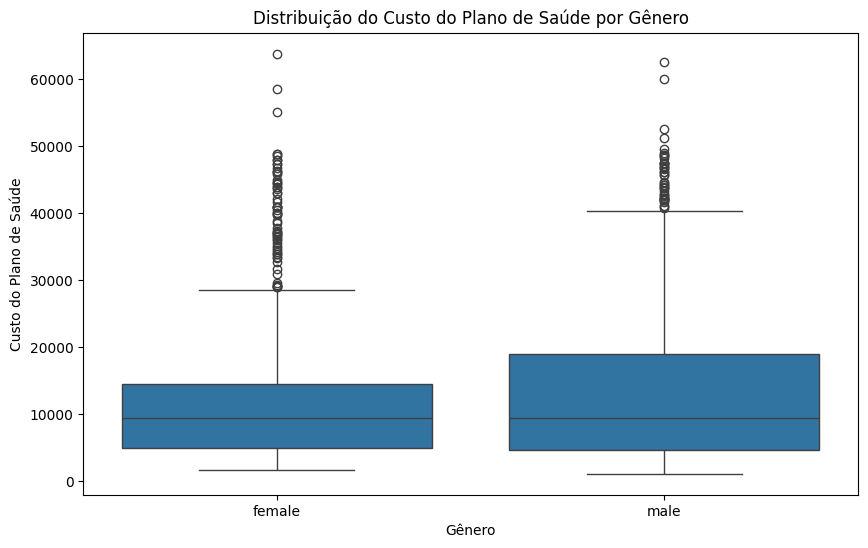

In [58]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=df, x='sex', y='charges')

plt.title("Distribuição do Custo do Plano de Saúde por Gênero")
plt.xlabel("Gênero")
plt.ylabel("Custo do Plano de Saúde")
plt.show()

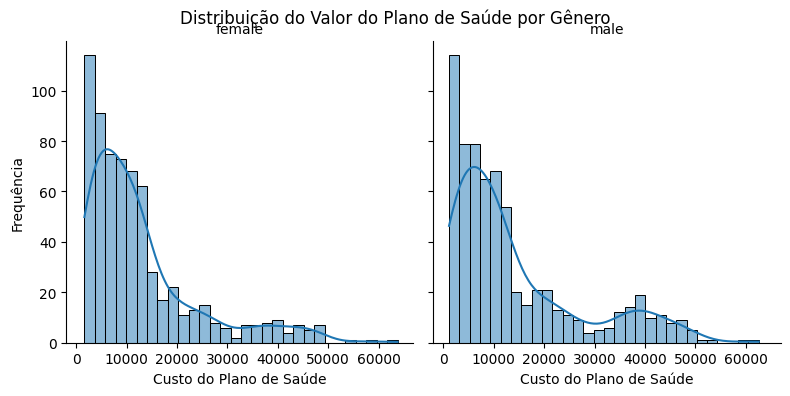

In [59]:
g = sns.FacetGrid(df, col="sex", col_wrap=2, height=4)
g.map_dataframe(sns.histplot, x="charges", bins=30, kde=True)

g.set_titles(col_template="{col_name}")
g.set_axis_labels("Custo do Plano de Saúde", "Frequência")
plt.subplots_adjust(top=0.9)
g.fig.suptitle("Distribuição do Valor do Plano de Saúde por Gênero")
plt.show()

# Separando os dados entre treino e teste

In [60]:
x = df_prepared.drop(columns=['charges'])
y = df_prepared['charges']

SEED = 27
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=SEED)

# Checando a distribuição dos dados

In [61]:
perc_sex_female_x = len(x_train[x_train['sex_female'] == 1]) / len(x_train)
print(perc_sex_female_x)

perc_sex_female = len(df_prepared[df_prepared['sex_female'] == 1]) / len(df_prepared)
print(perc_sex_female)

0.4953271028037383
0.4947683109118087


In [62]:
perc_smoker_x = len(x_train[x_train['smoker'] == 1]) / len(x_train)
print(perc_smoker_x)

perc_smoker = len(df_prepared[df_prepared['smoker'] == 1]) / len(df_prepared)
print(perc_smoker)

0.20654205607476636
0.20478325859491778


# Treinando os modelos

In [63]:
modelLinearRegression = LinearRegression()

modelLinearRegression.fit(x_train, y_train)

y_pred = modelLinearRegression.predict(x_test)
print("MSE:", mean_squared_error(y_test, y_pred))
print("R2:", r2_score(y_test, y_pred))

MSE: 39464205.47509551
R2: 0.731895259704691


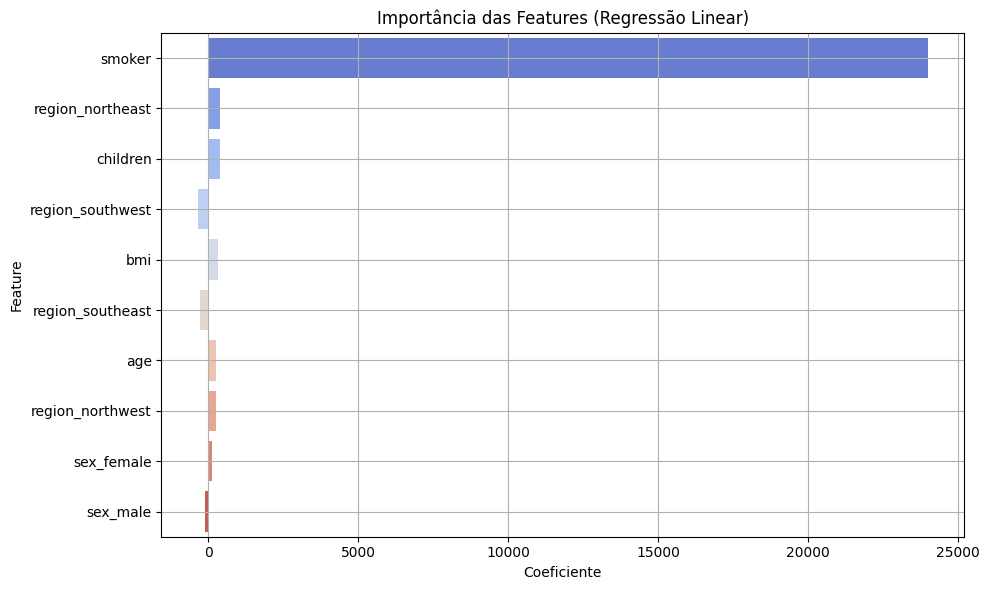

In [64]:
coefficients = modelLinearRegression.coef_
feature_names = x_train.columns
importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': coefficients
}).sort_values(by='importance', key=abs, ascending=False)
plt.figure(figsize=(10, 6))
sns.barplot(data=importance_df, x='importance', y='feature', palette='coolwarm')
plt.title('Importância das Features (Regressão Linear)')
plt.xlabel('Coeficiente')
plt.ylabel('Feature')
plt.grid(True)
plt.tight_layout()
plt.show()

In [65]:
modelDecisionTreeRegressor= DecisionTreeRegressor(random_state=SEED)
modelDecisionTreeRegressor.fit(x_train, y_train)
y_pred = modelDecisionTreeRegressor.predict(x_test)

print("MSE:", mean_squared_error(y_test, y_pred))
print("R2:", r2_score(y_test, y_pred))

MSE: 49558250.39402598
R2: 0.6633201735236993


In [66]:
modelRandomForestRegressor = RandomForestRegressor(n_estimators=100, random_state=SEED)
modelRandomForestRegressor.fit(x_train, y_train)
y_pred = modelRandomForestRegressor.predict(x_test)

print("MSE:", mean_squared_error(y_test, y_pred))
print("R2:", r2_score(y_test, y_pred))


MSE: 29734313.173886497
R2: 0.7979964320737428


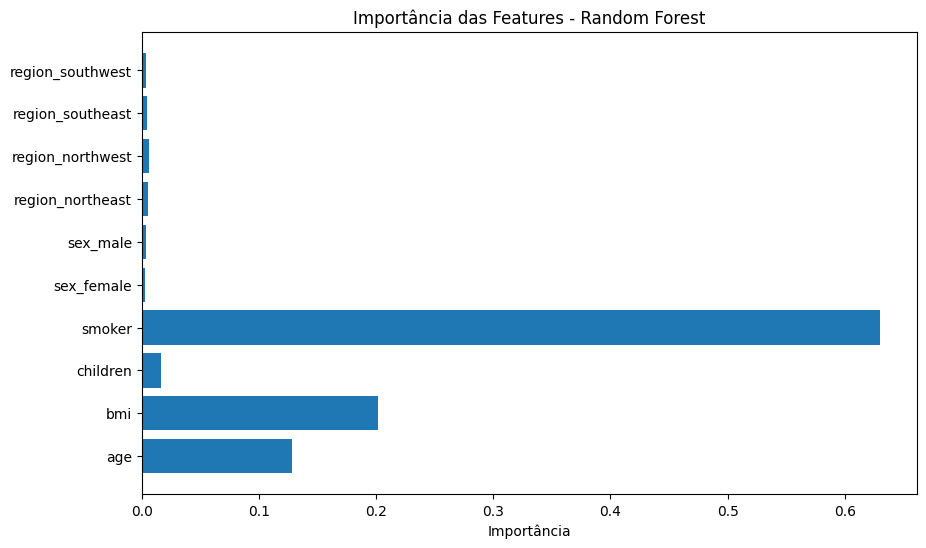

In [67]:
importances = modelRandomForestRegressor.feature_importances_
feature_names = x_train.columns

# Cria um gráfico
plt.figure(figsize=(10, 6))
plt.barh(feature_names, importances)
plt.xlabel("Importância")
plt.title("Importância das Features - Random Forest")
plt.show()

# Comparando com um modelo Dummy

In [68]:
dummy = DummyRegressor(strategy="mean")
dummy.fit(x_train, y_train)
y_dummy_pred = dummy.predict(x_test)

print("Mean")
print("MSE Dummy:", mean_squared_error(y_test, y_dummy_pred))
print("R2 Dummy:", r2_score(y_test, y_dummy_pred))

print("\n")

dummy = DummyRegressor(strategy="median")
dummy.fit(x_train, y_train)
y_dummy_pred = dummy.predict(x_test)

print("Median")
print("MSE Dummy:", mean_squared_error(y_test, y_dummy_pred))
print("R2 Dummy:", r2_score(y_test, y_dummy_pred))

Mean
MSE Dummy: 147198030.03458947
R2 Dummy: -7.199924736411845e-06


Median
MSE Dummy: 163142285.4391784
R2 Dummy: -0.10832638190211141


# Utilizando pipeline

In [69]:
x = df.drop(columns=['charges'])
y = df['charges']
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=SEED)

In [70]:
def encode_smoker(X):
  X_np = X.to_numpy()
  return (X_np.ravel() == 'yes').astype(int).reshape(-1, 1)


smoker_transformer = FunctionTransformer(encode_smoker)
onehot_transformer = OneHotEncoder(sparse_output=False, handle_unknown='ignore')

onehot_features = ['sex', 'region']

preprocessor = ColumnTransformer(
    transformers=[
        ('onehot', onehot_transformer, onehot_features),
        ('smoker_label', smoker_transformer, ['smoker'])
    ],
    remainder='passthrough'
)
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model', RandomForestRegressor(n_estimators=100, random_state=SEED))
])

param_grid = {
    'model__n_estimators': [50, 100, 200],
    'model__max_depth': [5, 10, 20],
    'model__min_samples_split': [2, 5, 10]
}

grid_search = GridSearchCV(
    pipeline,
    param_grid,
    cv=5,
    scoring='r2'
)

grid_search.fit(x_train, y_train)

print("Melhores parâmetros:", grid_search.best_params_)
print("Melhor score (R2) no treino (CV):", grid_search.best_score_)

y_pred = grid_search.predict(x_test)
print("Teste R2:", r2_score(y_test, y_pred))


Melhores parâmetros: {'model__max_depth': 5, 'model__min_samples_split': 10, 'model__n_estimators': 200}
Melhor score (R2) no treino (CV): 0.8628654551304008
Teste R2: 0.8238143326153495


# Persistindo o modelo.

In [71]:
drive.mount('/content/drive')

Mounted at /content/drive


In [72]:
path = '/content/drive/MyDrive/models/fiap_tech_challenge_healthcare-v2.joblib'
joblib.dump(grid_search.best_estimator_, path)

['/content/drive/MyDrive/models/fiap_tech_challenge_healthcare-v2.joblib']

# E se treinar o modelo com os dados escalados?

In [73]:
from sklearn.preprocessing import StandardScaler

x = df.drop(columns=['charges'])
y = df['charges']
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=SEED)

def encode_smoker(X):
  X_np = X.to_numpy()
  return (X_np.ravel() == 'yes').astype(int).reshape(-1, 1)


smoker_transformer = FunctionTransformer(encode_smoker)
onehot_transformer = OneHotEncoder(sparse_output=False, handle_unknown='ignore')

onehot_features = ['sex', 'region']

preprocessor = ColumnTransformer(
    transformers=[
        ('onehot', onehot_transformer, onehot_features),
        ('smoker_label', smoker_transformer, ['smoker'])
    ],
    remainder='passthrough'
)
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('scaler', StandardScaler()),
    ('model', RandomForestRegressor(n_estimators=100, random_state=SEED))
])

param_grid = {
    'model__n_estimators': [50, 100, 200],
    'model__max_depth': [5, 10, 20],
    'model__min_samples_split': [2, 5, 10]
}

grid_search = GridSearchCV(
    pipeline,
    param_grid,
    cv=5,
    scoring='r2'
)

grid_search.fit(x_train, y_train)

print("Melhores parâmetros:", grid_search.best_params_)
print("Melhor score (R2) no treino (CV):", grid_search.best_score_)

y_pred = grid_search.predict(x_test)
print("Teste R2:", r2_score(y_test, y_pred))

Melhores parâmetros: {'model__max_depth': 5, 'model__min_samples_split': 10, 'model__n_estimators': 200}
Melhor score (R2) no treino (CV): 0.8627977098846451
Teste R2: 0.8237389925988233
